In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAE
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

In [4]:
# ---------------------------
# 1. CARGA Y PREPROCESAMIENTO DEL DATASET
# ---------------------------
tickets = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]
dfs = []
i = 0
for ticket in tickets:
    df = pd.read_csv(f'../Data/Global_Data_{ticket}.csv', parse_dates=['Date'])
    df['unique_id'] = i  # Asigna un identificador numérico a cada ticket
    i += 1
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Definir las características (variables financieras y de sentimiento)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal', 
            'avg_sentiment', 'weighted_sentiment', 'sentiment_sma_7', 
            'sentiment_sma_14', 'tweet_count']

# Filtrar el DataFrame y ordenarlo
df_filt = df[['Date', 'unique_id'] + features]
df_filt = df_filt.sort_values(by=['unique_id', 'Date'])

# Reindexar para que cada 'unique_id' tenga un índice diario completo
dfs_with_full_dates = []
for unique_id in df_filt['unique_id'].unique():
    df_ticker = df_filt[df_filt['unique_id'] == unique_id]
    full_idx_ticker = pd.date_range(start=df_ticker['Date'].min(), end=df_ticker['Date'].max(), freq='D')
    df_ticker_reindexed = df_ticker.set_index('Date').reindex(full_idx_ticker).reset_index()
    df_ticker_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    df_ticker_reindexed['unique_id'] = unique_id
    dfs_with_full_dates.append(df_ticker_reindexed)
df_filt_full = pd.concat(dfs_with_full_dates, ignore_index=True)

# Imputar valores faltantes por interpolación lineal
df_filt_full[features] = df_filt_full[features].interpolate(method='linear')

# (Opcional) Se puede aplicar escalado; en este ejemplo se conserva la estructura original
df_scaled = pd.DataFrame(df_filt_full[features], columns=features, index=df_filt_full.index)
df_filt_full[features] = df_scaled

# ---------------------------
# 2. CREACIÓN DE VARIABLES NUEVAS (LAGS Y DIFERENCIAS)
# ---------------------------
# Variables FUTURAS exógenas: aquellas que se conocen para el pronóstico
# Por ejemplo, el cierre de hace 7 días (para predecir mañana o en el horizonte)
df_filt_full['y_lag7'] = df_filt_full.groupby('unique_id')['Close'].shift(7)
# Los indicadores técnicos (SMA_50, SMA_200, RSI, MACD y MACD_signal) ya se calculan con datos históricos y estarán disponibles

# Variables HISTÓRICAS exógenas: lags de variables cuyos valores futuros no se pueden "predecir"
# Lags de variables de precios:
for feat in ['Open', 'High', 'Low', 'Volume', 'Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']:
    df_filt_full[f"{feat}_lag7"] = df_filt_full.groupby('unique_id')[feat].shift(7)

# Lags de variables de sentimiento (ya que el análisis de sentimiento se hace en función de datos pasados)
for feat in ['weighted_sentiment', 'tweet_count', 'sentiment_sma_7']:
    df_filt_full[f"{feat}_lag7"] = df_filt_full.groupby('unique_id')[feat].shift(7)

# Opcional: calcular diferencias en el cierre para captar cambios recientes
df_filt_full['y_diff7'] = df_filt_full['Close'] - df_filt_full.groupby('unique_id')['Close'].shift(7)

# ---------------------------
# 3. PREPARAR EL DATASET FINAL PARA EL MODELO
# ---------------------------
# Renombrar 'Date' a 'ds' y 'Close' a 'y' (requerido por NeuralForecast)
df_filt_full = df_filt_full.fillna(0)
df_final = df_filt_full.rename(columns={'Date': 'ds', 'Close': 'y'})

# ---------------------------
# 4. DEFINICIÓN DE LISTAS DE VARIABLES EXÓGENAS
# Variables FUTURAS exógenas (futr_exog_list):
# Estas se conocen para la predicción (ejemplo: y_lag7 y los indicadores técnicos calculados con datos históricos).
futr_exog_list = [
    'Open_lag7', 'High_lag7', 'Low_lag7', 'Volume_lag7', 'Close_lag7',
    'y_diff7', 'SMA_50_lag7', 'SMA_200_lag7', 'RSI_lag7', 'MACD_lag7',
    'weighted_sentiment_lag7', 'sentiment_sma_7_lag7','tweet_count_lag7',
]

hist_exog_list = [
    'Open', 'High', 'Low', 'Volume', 'y',
    'SMA_50', 'SMA_200', 'RSI', 'MACD',
    'weighted_sentiment', 'sentiment_sma_7','tweet_count',
]
df_final

,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,...,Volume_lag7,Close_lag7,SMA_50_lag7,SMA_200_lag7,RSI_lag7,MACD_lag7,weighted_sentiment_lag7,tweet_count_lag7,sentiment_sma_7_lag7,y_diff7
0,2016-10-19,0,-1.923882,-1.940571,-1.987976,-1.923895,-0.843739,-2.227854,-2.383641,0.439562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-10-20,0,-1.925562,-1.951164,-1.916395,-1.934864,-0.541287,-2.222643,-2.380764,0.292853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-10-21,0,-1.921433,-1.948655,-1.911656,-1.933176,-0.552137,-2.219828,-2.379146,0.306937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-10-22,0,-1.917303,-1.946146,-1.906917,-1.931489,-0.562988,-2.217013,-2.377527,0.321021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2016-10-23,0,-1.913173,-1.943637,-1.902178,-1.929801,-0.573839,-2.214198,-2.375909,0.335104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019-12-27,4,2.078001,2.059150,2.101008,2.097364,-0.755330,1.872373,1.860070,1.736185,...,2.265131,2.016819,1.814937,1.820661,1.508624,1.439904,-1.640247,-0.570840,0.046008,0.080545
5841,2019-12-28,4,2.060497,2.052411,2.081831,2.091483,-0.814606,1.877174,1.863253,1.648411,...,1.238366,2.026664,1.819727,1.824098,1.559047,1.506800,-1.143412,-0.426814,0.047830,0.064819
5842,2019-12-29,4,2.042992,2.045672,2.062653,2.085602,-0.873882,1.881974,1.866436,1.560638,...,0.211602,2.036508,1.824516,1.827535,1.609470,1.573696,-0.646576,-0.282788,0.049651,0.049094
5843,2019-12-30,4,2.025487,2.038933,2.043476,2.079721,-0.933157,1.886774,1.869620,1.472865,...,-0.815163,2.046352,1.829306,1.830972,1.659893,1.640592,-0.149741,-0.138762,0.051473,0.033369


In [5]:
# Dividir en conjunto de entrenamiento y prueba
train = df_final[df_final['ds'] <= '2019-09-30']
test = df_final[(df_final['ds'] > '2019-09-30')].reset_index(drop=True)

print(train.shape[0])
print(test.shape[0])

5385
460


In [6]:
# Inicializar los modelos a evaluar
models = [
    # Modelo LSTM
    LSTM(
        h=7,
        input_size=20,
        encoder_n_layers=4,
        encoder_hidden_size=128,
        encoder_bias=True,
        encoder_dropout=0.2,
        decoder_hidden_size=128,
        decoder_layers=4,
        futr_exog_list=futr_exog_list,
        hist_exog_list=hist_exog_list,
        loss=MAE(),
        scaler_type='robust',
        learning_rate=1e-4,
        max_steps=400,
        batch_size=128,
    )
]

# Crear el objeto NeuralForecast y ajustar el modelo
nf = NeuralForecast(
    models=models,
    freq='D'  # Frecuencia diaria
)

Seed set to 1


In [7]:
nf.fit(df=train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 469 K  | train
4 | context_adapter | Linear        | 15.4 K | train
5 | mlp_decoder     | MLP           | 36.2 K | train
----------------------------------------------------------
521 K     Trainable params
0         Non-trainable params
521 K     Total params
2.085     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.


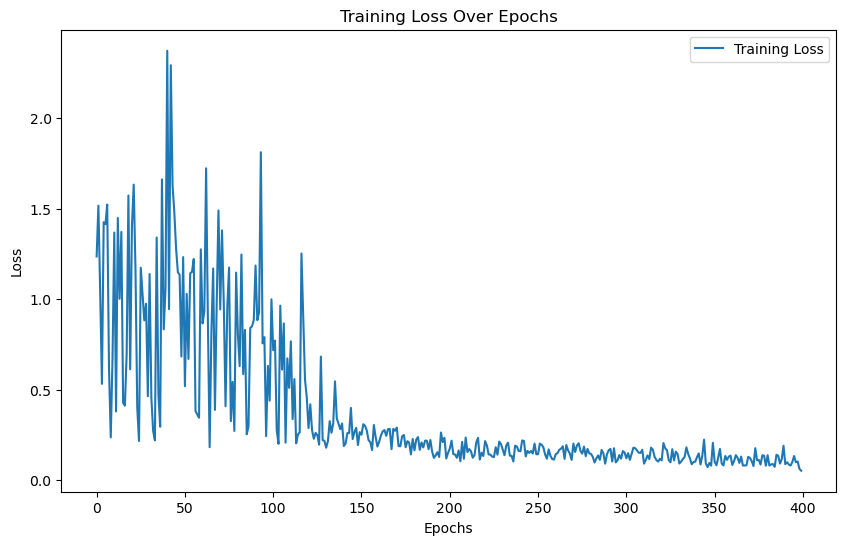

In [8]:
# Obtener el historial de pérdidas del modelo desde los resultados de entrenamiento
losses = nf.models[0].train_trajectories

# Extraer los valores de la pérdida y las épocas
epochs = [x[0] for x in losses]  # Épocas
train_loss = [x[1] for x in losses]  # Pérdidas

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")

# Añadir etiquetas y título
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Mostrar la gráfica
plt.show()

## Validación del Modelo

In [113]:
cv_result = nf.cross_validation(df=train, n_windows=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 469 K  | train
4 | context_adapter | Linear        | 15.4 K | train
5 | mlp_decoder     | MLP           | 36.2 K | train
----------------------------------------------------------
521 K     Trainable params
0         Non-trainable params
521 K     Total params
2.085     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Y_aapl = train[train['unique_id'] == 0][1050:]
Y_aapl

,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,...,Volume_lag7,Close_lag7,SMA_50_lag7,SMA_200_lag7,RSI_lag7,MACD_lag7,weighted_sentiment_lag7,tweet_count_lag7,sentiment_sma_7_lag7,y_diff7
1050,2019-09-04,0,0.653877,0.616204,0.657958,0.639521,-0.906318,0.764204,0.555577,-0.301317,...,-0.528655,0.646177,0.741663,0.549439,-0.204256,0.079782,-1.289519,-0.190542,-1.159984,-0.006657
1051,2019-09-05,0,0.768388,0.741367,0.776504,0.741056,-0.556967,0.772881,0.559744,0.038919,...,-0.645211,0.667741,0.747345,0.549924,-0.139564,0.060039,-1.111554,0.075867,-1.275611,0.073315
1052,2019-09-06,0,0.774617,0.758580,0.773392,0.761026,-0.494208,0.777810,0.561879,0.100180,...,-0.761768,0.689304,0.753027,0.550408,-0.074873,0.040295,-0.933590,0.342275,-1.391238,0.071722
1053,2019-09-07,0,0.780847,0.775793,0.770280,0.780995,-0.431449,0.782738,0.564014,0.161441,...,-0.782475,0.663077,0.754247,0.551061,-0.181736,0.027005,-0.325008,0.142469,-1.120347,0.117919
1054,2019-09-08,0,0.787076,0.793007,0.767168,0.800965,-0.368690,0.787667,0.566149,0.222701,...,-0.803182,0.636849,0.755467,0.551714,-0.288600,0.013714,0.283575,-0.057338,-0.849456,0.164116
1055,2019-09-09,0,0.793306,0.810220,0.764056,0.820934,-0.305931,0.792595,0.568284,0.283962,...,-0.823889,0.610621,0.756686,0.552367,-0.395464,0.000423,0.892158,-0.257144,-0.578565,0.210313
1056,2019-09-10,0,0.864140,0.819698,0.782163,0.793371,0.024413,0.802301,0.574548,0.149114,...,-0.844596,0.584393,0.757906,0.553020,-0.502328,-0.012867,1.500741,-0.456950,-0.307673,0.208977
1057,2019-09-11,0,1.057045,1.012878,0.952485,0.911782,0.949371,0.811829,0.581315,0.515003,...,-0.906318,0.639521,0.764204,0.555577,-0.301317,-0.018063,0.733266,-0.190542,-0.587844,0.272261
1058,2019-09-12,0,1.043046,1.088421,1.097626,1.101071,0.057592,0.826785,0.590114,0.973948,...,-0.556967,0.741056,0.772881,0.559744,0.038919,0.048251,-1.467483,-0.456950,-0.587844,0.360015
1059,2019-09-13,0,0.921536,0.931480,0.932397,0.966065,0.614753,0.837476,0.598191,0.362537,...,-0.494208,0.761026,0.777810,0.561879,0.100180,0.090864,-0.948988,-0.257144,-0.454669,0.205040


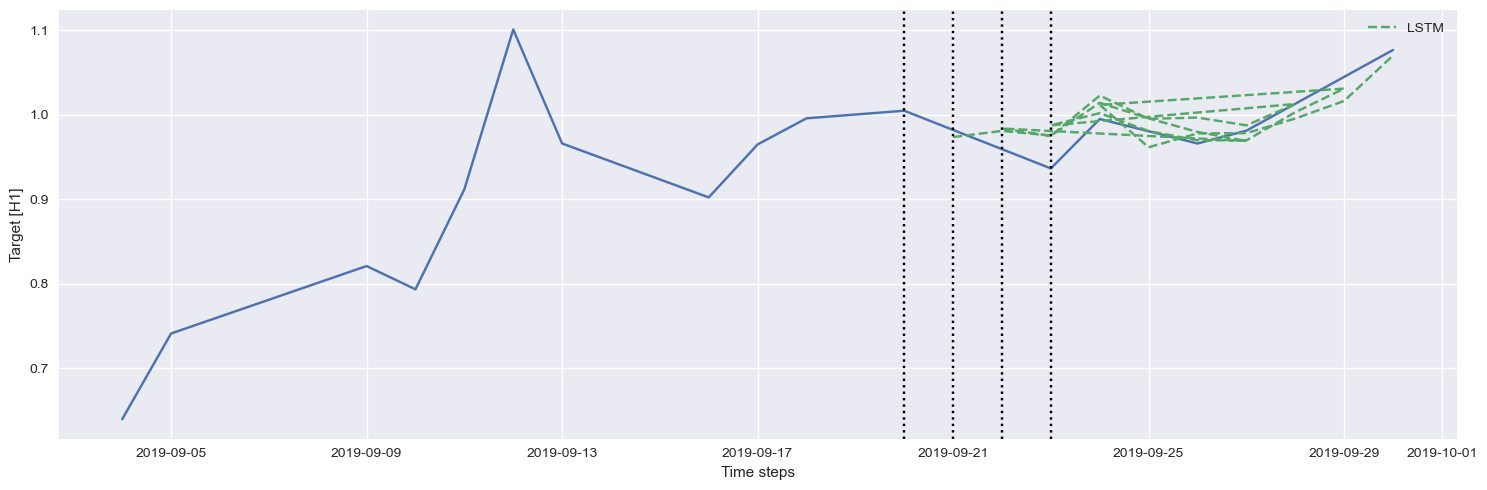

In [115]:
cv_res_appl = cv_result[cv_result['unique_id'] == 0]

cutoffs = cv_res_appl['cutoff'].unique()

plt.figure(figsize=(15,5))
plt.plot(Y_aapl['ds'], Y_aapl['y'])
plt.plot(cv_res_appl['ds'], cv_res_appl['LSTM'], label='LSTM', ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()

In [80]:
# Calcular las métricas de cada empresa
metrics = []

empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}

# Agrupar por empresa (unique_id)
for empresa_id, group in cv_result.groupby('unique_id'):
    y_true = group['y']
    y_pred = group['LSTM']
    
    # Calcular MAE, RMSE, MAPE para cada empresa
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.sqrt(mape)
    r2 = r2_score(y_true,y_pred)
    
    # Guardar los resultados
    metrics.append({
        'Empresa': empresa_dict[empresa_id],
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'R2': r2
    })

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics)

# Mostrar las métricas
print(metrics_df)

  Empresa       MAE       MSE      RMSE       MAPE     SMAPE        R2
0    AAPL  0.056067  0.004210  0.064886   8.161856  2.856896  0.888132
1    AMZN  0.103402  0.013710  0.117092  12.767878  3.573217 -2.362425
2    TSLA  0.048889  0.004042  0.063575   3.628795  1.904940  0.910860
3   GOOGL  0.062697  0.005117  0.071533   7.399103  2.720129  0.851289
4    MSFT  0.061940  0.006534  0.080832   5.020106  2.240559 -0.706367


## Evaluación del Modelo

In [73]:
# Realizar predicciones utilizando el conjunto de prueba y las variables exógenas futuras
forecasts = nf.predict(futr_df=test)
forecasts

c:\Users\pmyoe\anaconda3\Lib\site-packages\neuralforecast\core.py:904: UserWarning: Dropped 425 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM
0,0,2019-10-01,1.003735
1,0,2019-10-02,1.004842
2,0,2019-10-03,0.977858
3,0,2019-10-04,1.068223
4,0,2019-10-05,1.123524
5,0,2019-10-06,1.071690
6,0,2019-10-07,1.118845
7,1,2019-10-01,0.701878
8,1,2019-10-02,0.645649
9,1,2019-10-03,0.603303


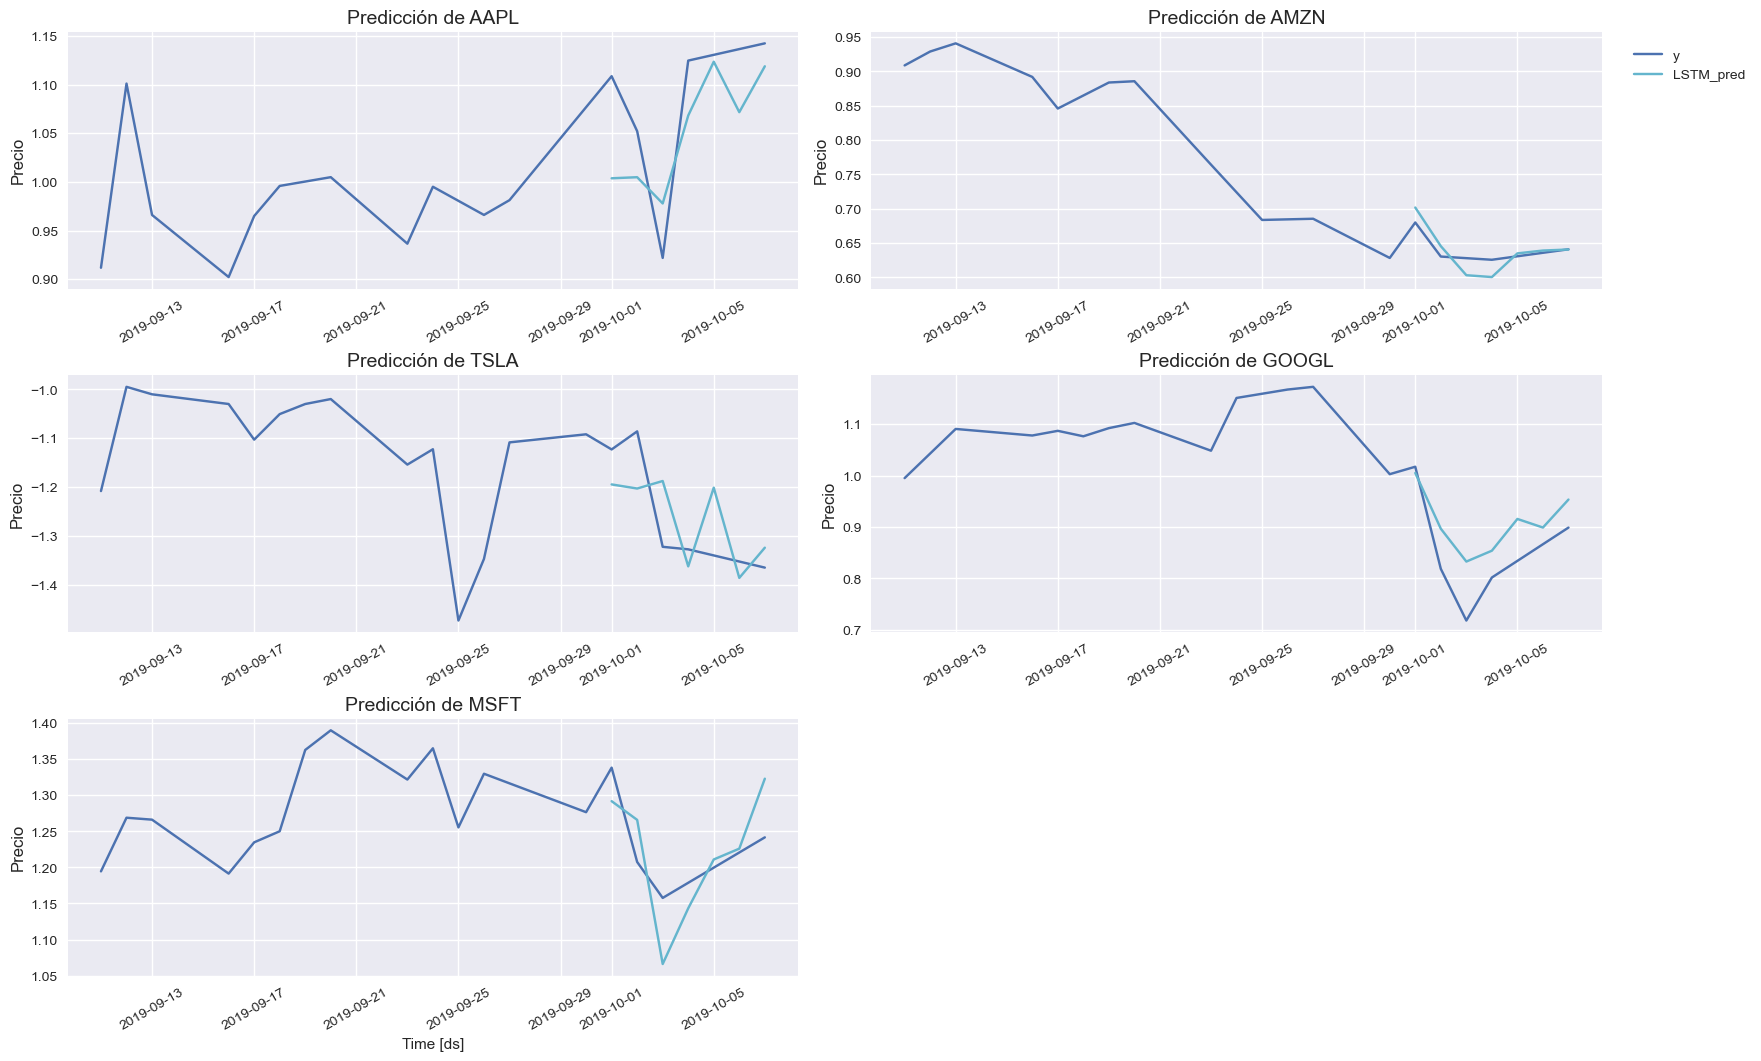

In [24]:
# Establecer el estilo de las gráficas
plt.style.use('seaborn-v0_8')

# Filtrar los datos para el rango de fechas especificado
df_filtered = df_final[(df_final['ds'] > '2019-09-10') & (df_final['ds'] <= '2019-10-07')]


# Graficar con plot_series (la función retorna una figura, no un par de valores)
fig = plot_series(
    df_filtered,         # Datos reales
    forecasts_df=forecasts,  # Predicciones
    engine='matplotlib',     # Usar matplotlib como motor de gráficos
    id_col='unique_id',      # Columna que identifica las series (empresas)
    time_col='ds',           # Columna de fechas
    target_col='y',          # Columna de la variable objetivo
    plot_random=False,       # No graficar aleatoriamente
)

# Diccionario que mapea unique_id con nombres de empresas
empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}  # Ejemplo

# Acceder a los ejes y añadir títulos
# Acceder a los ejes y añadir títulos
for ax, unique_id in zip(fig.axes, forecasts['unique_id'].unique()):
    # Obtener el nombre de la empresa desde el diccionario
    nombre_empresa = empresa_dict.get(unique_id, "Empresa Desconocida")  # Mapeo al nombre de la empresa
    
    # Establecer título con el nombre de la empresa
    ax.set_title(f"Predicción de {nombre_empresa}", fontsize=14)
    
    # Cambiar el título del eje y
    ax.set_ylabel('Precio', fontsize=12)

# Mostrar la gráfica
fig

In [120]:
# Renombrar la predicción del modelo TFT
forecasts = forecasts.rename(columns={'LSTM_pred': 'LSTM'})  

# Fusionar predicciones con el conjunto de prueba usando sufijos para evitar columnas duplicadas
test = test.merge(forecasts, on=['ds', 'unique_id'], how='left', suffixes=('', '_forecast'))

# Evaluar el modelo TFT
evaluation = evaluate(
    df=test,  # Conjunto de prueba con predicciones
    metrics=[mae, mse, rmse, mape, smape],  # Métricas de error
    models=['LSTM']  # Modelo a evaluar
)

# Agrupar por empresa y métrica
summary_by_company = evaluation.groupby(['unique_id', 'metric']).mean().reset_index()

# Pivotar el DataFrame para que cada métrica sea una columna
summary_pivot = summary_by_company.pivot(index='unique_id', columns='metric', values='LSTM').reset_index()

# Renombrar las compañías en la columna 'unique_id'
companies = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]
summary_pivot['unique_id'] = companies

# Eliminar el índice 'metric' si está presente
summary_pivot = summary_pivot.reset_index(drop=True)

# Renombrar la columna 'unique_id' a 'Empresa'
summary_pivot = summary_pivot.rename(columns={'unique_id': 'Empresa'})

# Convertir las métricas a mayúsculas
summary_pivot.columns = [col.upper() if col not in ['EMPRESA'] else col for col in summary_pivot.columns]

# Eliminar cualquier columna que sea un índice residual
summary_pivot.columns.name = None  # Esto elimina el nombre del índice

# Mostrar el resultado
summary_pivot


,EMPRESA,MAE,MAPE,MSE,RMSE,SMAPE
0,AAPL,0.051445,0.047775,0.003482,0.059008,0.001856
1,AMZN,0.013540,0.021171,0.000283,0.016837,0.000810
2,TSLA,0.081519,0.065348,0.008584,0.092651,0.002505
3,GOOGL,0.060873,0.075523,0.004697,0.068535,0.002736
4,MSFT,0.047129,0.038799,0.003142,0.056053,0.001482
